<h1>ASSIGNMENT 7 : SVM on Amazon Fine Food Reviews</h1>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

<strong> OBJECTIVES :</strong>
    - Featurization/ Vectorization : Bow, tf-idf, avg w2v, tf-idf w2v
    - Train & Test Split : Time based slicing (70:30)
    - Cross validation : k-fold cv to find optimal c for each Vectorization
    - Test accuracy,f1 score,precsion,confusion matrix applied on all vectorization
    - Optimal C Techniques : GridSearchCV and RandomSearchCV
    - Regularisation : L1 and L2

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [60]:
# Loading Pre-Processed data( Reviews ) from database
conn = sqlite3.connect('final_database.sqlite')
data = pd.read_sql_query('''SELECT * FROM Reviews''',conn)

In [61]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [62]:
data.shape

(364171, 12)

In [63]:
# Sorting data in ascending order wrt time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")

In [64]:
data["Score"].value_counts()

positive    307061
negetive     57110
Name: Score, dtype: int64

In [65]:
def Partition(x):
    if x == "positive":
        return 1
    else:
        return 0
    
actual_score = data['Score']
pone = actual_score.map(Partition)
data['Score'] = pone

data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [66]:
data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [67]:
X = data["CleanText"]
y = data["Score"]

In [68]:
#Splitting sampe data in train and test dataset in  70:30
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 0)
print(X_train.shape, X_test.shape)

(254919,) (109252,)


In [69]:
#Sampling 100k data pts in 70:30 train test

X_tr = X_train.iloc[1:70001]
y_tr = y_train.iloc[1:70001]
Xt = X_test.iloc[1:30001]
yt = y_test.iloc[1:30001]

print(X_tr.shape,Xt.shape)

(70000,) (30000,)


In [70]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve

def Linear_SVM(X_tr,y_tr,Xt,yt):
    model = SGDClassifier()
    model.fit(X_tr, y_tr)
    
    clf = CalibratedClassifierCV(model, cv='prefit')
    clf.fit(X_tr, y_tr)
    
    pred = clf.predict(Xt)
    cm = confusion_matrix(yt, pred)
    print("\nConfusion Matrix :")
    print(cm)
    
    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("CONFUSION MATRIX ")
    plt.show()
    
    acc = accuracy_score(yt, pred, normalize=True) * float(100)
    print('\n****Test accuracy  is %d%%' % (acc))
    
    f1 = f1_score(yt, pred, average='weighted')
    print("\n F1  score is "+str(f1))
    
    prs = precision_score(yt, pred, average='weighted')
    print("\nprecision score is "+str(prs))
    
    rcs = recall_score(yt, pred, average='weighted')
    print("\nrecall score is "+str(rcs))

    fop, mpv = calibration_curve(pred, yt, n_bins=10, normalize=True)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Calibration Curve for Linear SVM ")
    plt.show()


In [76]:
#function to find top feaures
import itertools
def show_most_informative_features(vectorizer, n=25):
    model = SGDClassifier()
    model.fit(Xtr, y_tr)
    
    clf = CalibratedClassifierCV(model, cv='prefit')
    clf.fit(Xtr, y_tr)
    
    model.fit(Xtr, y_tr)
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(model.coef_ [0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegetive\t\t\t\t\t\tPositve")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t\t%s\t\t\t\t\t%s" % ( fn_1,  fn_2))


<strong>Linear SVM</strong>

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning.The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net)

<h3>BoW</h3>

In [17]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_tr = count_vect.fit_transform(X_tr)
Xt = count_vect.transform(Xt)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(X_tr)
scaler.transform(Xt)

<30000x61998 sparse matrix of type '<class 'numpy.float64'>'
	with 945853 stored elements in Compressed Sparse Row format>

<strong>Linear SVM</strong>


Confusion Matrix :
[[ 2858  1893]
 [  866 24383]]


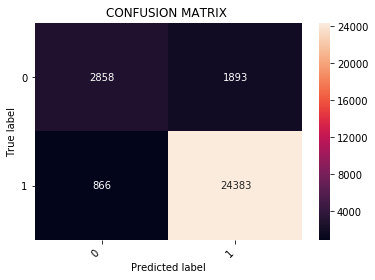


****Test accuracy  is 90%

precision score is 0.903377618814935

precision score is 0.9025387901868168

recall score is 0.9080333333333334


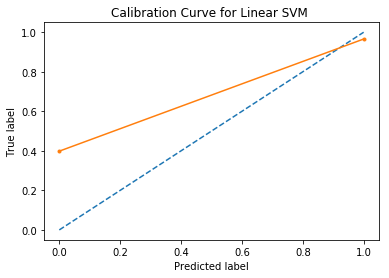

In [19]:
Linear_SVM(X_tr,y_tr,Xt,yt)

<strong>Top 25 features from both negetaive and positive class</strong>

In [20]:
show_most_informative_features(count_vect, n=25)

		Negetive						Positve
________________________________________________________________________________________________
		worst					worri
		tasteless					hesit
		terribl					delici
		aw					amaz
		disappoint					downsid
		disgust					awesom
		poor					hook
		ripoff					build
		horribl					complaint
		ruin					best
		weak					skeptic
		return					smooth
		unpleas					excel
		unfortun					terrif
		threw					pleasant
		yuck					perfect
		mislead					superb
		concept					whenev
		danger					heaven
		mediocr					ultim
		rancid					addict
		wors					drawback
		sorri					fantast
		stale					beat
		cancel					satisfi


In [21]:
# Reducing dimensions and converting sparse matrix to dense matrix using Truncated SVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=70, random_state=0)
X_tr = svd.fit_transform(X_tr)
Xt = svd.transform(Xt)

In [22]:
print(X_tr.shape,Xt.shape)

(70000, 70) (30000, 70)


<strong>RBF kernel (using SVC)</strong>

In [23]:
tuned_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0, 10,10**2]}]
tscv = TimeSeriesSplit(n_splits=3)
model = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'f1_weighted', cv=tscv)
model.fit(X_tr, y_tr)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [24]:
print(model.best_estimator_)
print("\nF1 score is :")

pred = model.predict(Xt)
cm = confusion_matrix(yt, pred)
print("\nConfusion Matrix :")
print(cm)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

F1 score is :

Confusion Matrix :
[[ 1562  3189]
 [ 1042 24207]]



F1 score is :
0.8412579808450228

Confusion Matrix :
[[ 1562  3189]
 [ 1042 24207]]

****Test accuracy  is 85%

precision score is 0.8386596425156757

recall score is 0.8589666666666667


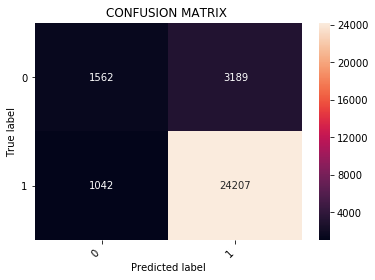

In [28]:
print("\nF1 score is :")
print(model.score(Xt, yt))
    
pred = model.predict(Xt)
cm = confusion_matrix(yt, pred)
print("\nConfusion Matrix :")
print(cm)
plt.figure()
heatmap = sns.heatmap(cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("CONFUSION MATRIX ")
    
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy  is %d%%' % (acc))
    
prs = precision_score(yt, pred, average='weighted')
print("\nprecision score is "+str(prs))

rcs = recall_score(yt, pred, average='weighted')
print("\nrecall score is "+str(rcs))

<h3>tf-idf</h3>

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
Xtr = tf_idf_vect.fit_transform(X_tr)
X_t = tf_idf_vect.transform(Xt)

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(Xtr)
scaler.transform(X_t)

<30000x61998 sparse matrix of type '<class 'numpy.float64'>'
	with 945853 stored elements in Compressed Sparse Row format>

<strong>Linear SVM</strong>


Confusion Matrix :
[[ 3057  1694]
 [  790 24459]]


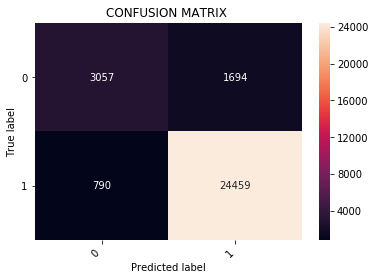


****Test accuracy  is 91%

 F1  score is 0.9135752699443678

precision score is 0.9129637915714063

recall score is 0.9172


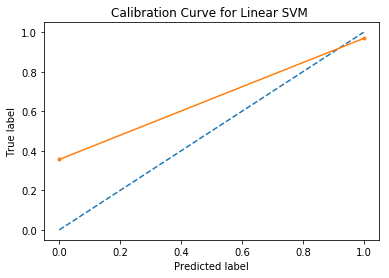

In [74]:
Linear_SVM(Xtr,y_tr,X_t,yt)

<strong>Top 25 features from both negetaive and positive class</strong>

In [77]:
show_most_informative_features(tf_idf_vect, n=25)

		Negetive						Positve
________________________________________________________________________________________________
		disappoint					great
		worst					love
		return					best
		terribl					delici
		aw					good
		horribl					perfect
		wast					nice
		unfortun					excel
		stale					amaz
		disgust					favorit
		threw					happi
		money					wonder
		weak					worri
		poor					keep
		refund					awesom
		tasteless					smooth
		bland					easi
		wors					thank
		bad					tasti
		gross					find
		descript					addict
		mayb					enjoy
		tast					definit
		yuck					without
		sorri					yummi


In [19]:
# Reducing dimensions and converting sparse matrix to dense matrix using Truncated SVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=70, random_state=0)
Xtr = svd.fit_transform(Xtr)
X_t = svd.transform(X_t)

<strong>RBF kernel (using SVC)</strong>

In [20]:
tuned_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0, 10,10**2]}]
tscv = TimeSeriesSplit(n_splits=3)
model = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'f1_weighted', cv=tscv)
model.fit(Xtr, y_tr)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)


Confusion Matrix :
[[ 1499  3252]
 [  548 24701]]

f1 score is 0.8513605368843017

****Test accuracy  is 87%

precision score is 0.8596897872858944

recall score is 0.8733333333333333


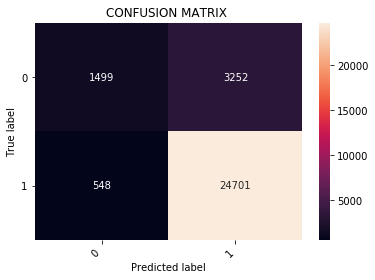

In [23]:

pred = model.predict(X_t)
cm = confusion_matrix(yt, pred)
print("\nConfusion Matrix :")
print(cm)
plt.figure()
heatmap = sns.heatmap(cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("CONFUSION MATRIX ")
   
f1 = f1_score(yt, pred, average='weighted')
print("\nf1 score is "+str(f1))
    
    
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy  is %d%%' % (acc))
    
prs = precision_score(yt, pred, average='weighted')
print("\nprecision score is "+str(prs))
    
rcs = recall_score(yt, pred, average='weighted')
print("\nrecall score is "+str(rcs))

<h3>word2vec</h3>

In [38]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in X_tr.values: 
    list_of_sent.append(sent.split())

In [39]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent_test=[]
for sent in Xt.values: 
    list_of_sent_test.append(sent.split())

In [40]:
# min_count = 5 considers only words that occured atleast 5 times
import warnings
warnings.filterwarnings("ignore")

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [41]:
w2v_words = list(w2v_model.wv.vocab)

<h3>Average Word2Vec </h3>

In [65]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [66]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [67]:
X_tr = sent_vectors
Xt = sent_vectors_test

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
Xt = scaler.transform(Xt)

<strong> Linear SVM </strong>


Confusion Matrix :
[[ 1581  3170]
 [  731 24518]]


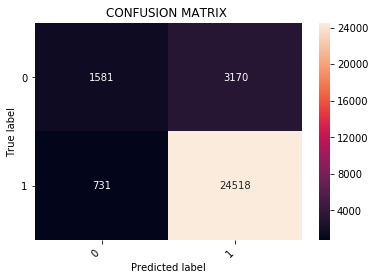


****Test accuracy  is 86%

 F1  score is 0.8505106209292047

precision score is 0.8535695591917785

recall score is 0.8699666666666667


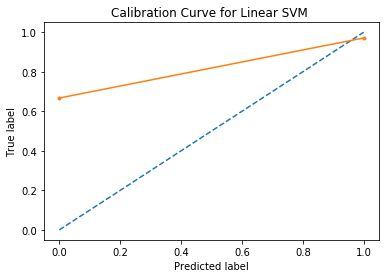

In [48]:
Linear_SVM(X_tr,y_tr,Xt,yt)

<strong>RBF kernel (using SVC)</strong>

In [69]:
tuned_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0, 10,10**2]}]
tscv = TimeSeriesSplit(n_splits=3)
model = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'f1_weighted', cv=tscv)
model.fit(X_tr, y_tr)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)


Confusion Matrix :
[[ 2578  2173]
 [  966 24283]]

f1 score is 0.8889753816019019

****Test accuracy  is 89%

precision score is 0.8877047519279281

recall score is 0.8953666666666666


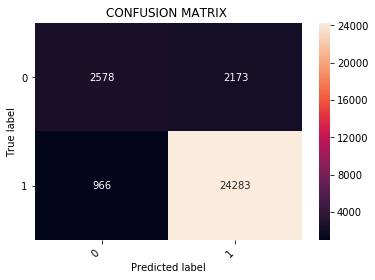

In [70]:
pred = model.predict(Xt)
cm = confusion_matrix(yt, pred)
print("\nConfusion Matrix :")
print(cm)
plt.figure()
heatmap = sns.heatmap(cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("CONFUSION MATRIX ")
    
f1 = f1_score(yt, pred, average='weighted')
print("\nf1 score is "+str(f1))    
    
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy  is %d%%' % (acc))
    
prs = precision_score(yt, pred, average='weighted')
print("\nprecision score is "+str(prs))

rcs = recall_score(yt, pred, average='weighted')
print("\nrecall score is "+str(rcs))

<h3>Tf-Idf Word2Vec </h3>

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
from tqdm import tqdm

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:31<00:00, 463.28it/s]


In [44]:
train = tfidf_sent_vectors

In [45]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
from tqdm import tqdm

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:12<00:00, 411.76it/s]


In [46]:
test = tfidf_sent_vectors_test

<strong>Linear SVM</strong>


Confusion Matrix :
[[ 1662  3089]
 [  799 24450]]


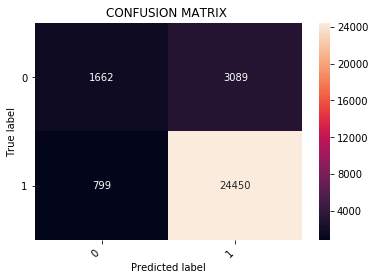


****Test accuracy  is 87%

 F1  score is 0.8526353862755831

precision score is 0.8541794282922971

recall score is 0.8704


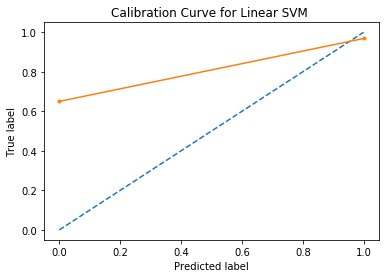

In [27]:
Linear_SVM(train,y_tr,test,yt)

<strong>RBF kernel (using SVC)</strong>

In [47]:
tuned_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0, 10,10**2]}]
tscv = TimeSeriesSplit(n_splits=3)
model = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'f1_weighted', cv=tscv)
model.fit(train, y_tr)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)


Confusion Matrix :
[[ 2268  2483]
 [  886 24363]]

f1 score is 0.8780776585980983

****Test accuracy  is 88%

precision score is 0.8776696356059085

recall score is 0.8877


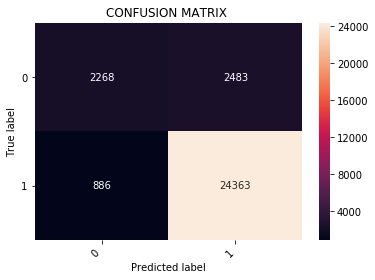

In [48]:
pred = model.predict(test)
cm = confusion_matrix(yt, pred)
print("\nConfusion Matrix :")
print(cm)
plt.figure()
heatmap = sns.heatmap(cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("CONFUSION MATRIX ")
    
f1 = f1_score(yt, pred, average='weighted')
print("\nf1 score is "+str(f1))    
    
acc = accuracy_score(yt, pred, normalize=True) * float(100)
print('\n****Test accuracy  is %d%%' % (acc))
    
prs = precision_score(yt, pred, average='weighted')
print("\nprecision score is "+str(prs))

rcs = recall_score(yt, pred, average='weighted')
print("\nrecall score is "+str(rcs))

<h2>Conclusion</h2>

Here we have considered 100k data points

In [59]:
table = {'Technique':['BoW', "TFIDF","Avg_w2v","tf-idf_w2v"],'F1 score Lnr':[0.9035,0.9143,0.85,0.8526],'C in RBF kernel':[1,1,1,1],'F1 score RBF':[0.8412,0.8514,0.8889,0.8780] }
df = pd.DataFrame(data=table)
df

,Technique,F1 score Lnr,C in RBF kernel,F1 score RBF
0,BoW,0.9035,1,0.8412
1,TFIDF,0.9143,1,0.8514
2,Avg_w2v,0.8500,1,0.8889
3,tf-idf_w2v,0.8526,1,0.8780


    -Support Vector Machine(SVM) gave the best result better than other algos close to Logistic Regression
    -Linear SVM can be implimented directly through SGDClassifier(default as Linear).
    -Linear SVM performed very fast compared to RBF kernel.
    -RBF kernel performed quite well than SGDClassifier.